# Solving Krusell Smith Model with HARK and SSJ

By William Du

In [1]:
from ConsIndShockModel_HANK import IndShockConsumerType        # functions
import matplotlib.pyplot as plt
import numpy as np
import time

from scipy import optimize

from sequence_jacobian.classes import JacobianDict, SteadyStateDict
from sequence_jacobian import het, simple, create_model              # functions
import sequence_jacobian as sj  # SSJ will allow us to define blocks, models, compute IRFs, etc

In [2]:
calibration = {'eis': 1, 'delta': 0.025, 'alpha': 0.11, 'L': 1.0,'K': 1.0, 'Y': 1.0, 'r': .01, 'L': 1.0}

In [3]:
L_ss = 1.0 # Steady state labor
r_ss = .01 # steady state interest rate
Y_ss = 1.0 # steady state output

## 

Given these steady state choices, we will need to find $K, Z$ to clear the firm first order conditions.


In [4]:
from scipy.optimize import root    

def your_funcs(X):
    
    L = calibration['L']
    alpha = calibration['alpha']
    delta = calibration['delta']

    K, Z = X
    # all RHS have to be 0
    f = [alpha * Z * (K / L) ** (alpha-1) - delta - r_ss, #r = MPK
         Z * K ** alpha * L ** (1 - alpha) - Y_ss # Y = Z*F(K,L)
        ]

    return f

sol = root(your_funcs, [1.0, 1.0]) # find roots

K_ss,Z_ss = sol.x

In [5]:
print(sol)

 message: The solution converged.
 success: True
  status: 1
     fun: [ 1.749e-14 -5.218e-15]
       x: [ 3.143e+00  8.816e-01]
    nfev: 14
    fjac: [[-3.675e-01  9.300e-01]
           [-9.300e-01 -3.675e-01]]
       r: [ 3.906e-02  1.143e+00 -3.236e-01]
     qtf: [-4.533e-12 -5.621e-12]


 Let's double check the roots we find produce our chosen steady state values for $ r, Y , L$.

In [6]:
def firm(K,Z, L = calibration['L'],alpha = calibration['alpha'], delta = calibration['delta']):   
    r = alpha * Z * (K / L) ** (alpha-1) - delta
    w = (1 - alpha) * Z * (K / L) ** alpha
    Y = Z * K ** alpha * L ** (1 - alpha)
    return r, w, Y

r_ss,w_ss,Y_ss = firm(sol.x[0],sol.x[1])



In [7]:
print(r_ss,w_ss,Y_ss )

0.010000000000017495 0.8899999999999955 0.9999999999999948


In [8]:
HANK_Dict = {
    # Parameters shared with the perfect foresight model
    "CRRA":calibration['eis'],                              # Coefficient of relative risk aversion
    "Rfree": (1+r_ss),                    # Interest factor on assets
    "DiscFac": 0.98,                      # Intertemporal discount factor
    "LivPrb" : [.99375],                   # Survival probability
    "PermGroFac" : [1.00],                 # Permanent income growth factor

    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd" : [.06],                  # Standard deviation of log permanent shocks to income
    "PermShkCount" : 5,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [0.2],                  # Standard deviation of log transitory shocks to income
    "TranShkCount" : 5,    
    
    # HANK params
    "taxrate" : [0], # set to 0.0 because we are going to assume that labor here is actually after tax income
    "labor": [L_ss],
    "wage": [w_ss],    
    
    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : 0.0,                      # Probability of unemployment while working
    "IncUnemp" :  0.0,                     # Unemployment benefits replacement rate
    "UnempPrbRet" : 0.0000,                # Probability of "unemployment" while retired
    "IncUnempRet" : 0.0,                   # "Unemployment" benefits when retired
    "T_retire" : 0.0,                      # Period of retirement (0 --> no retirement)
    "tax_rate" : 0.0,                      # Flat income tax rate (legacy parameter, will be removed in future)

    # Parameters for constructing the "assets above minimum" grid
    "aXtraMin" : 0.0001,                    # Minimum end-of-period "assets above minimum" value
    "aXtraMax" : 2000,                      # Maximum end-of-period "assets above minimum" value
    "aXtraCount" :200,                     # Number of points in the base grid of "assets above minimum"
    "aXtraNestFac" : 3,                    # Exponential nesting factor when constructing "assets above minimum" grid
    "aXtraExtra" : [None],                 # Additional values to add to aXtraGrid
    
    # Transition Matrix simulation parameters
    "mCount": 200,
    "mMax":2000,
    "mMin": 0.0001,
    "mFac": 3,
}

In [9]:
def function(taxrate, labor, wage):
    
    z = labor*wage # labor income attached to transitory and permanent shocks
    return z


HANK_Dict['TranShkMean_Func'] = [function]


# Create HARK agent

In [10]:
Agent = IndShockConsumerType(**HANK_Dict)

# Find Steady state discount factor clear asset market

We will estimate the discount factor to ensure that asset supply equals the steady state capital we found earlier. 



In [11]:
def A_ss_func(beta):
    HANK_Dict['DiscFac'] = beta

    Agent_func = IndShockConsumerType(**HANK_Dict, verbose = False)
    A_ss = Agent_func.compute_steady_state()[0]
    
    return A_ss
    

def ss_dif(beta):    
    return A_ss_func(beta) - Asset_target 
start  = time.time()
Asset_target = K_ss

DiscFac = optimize.brentq(ss_dif,.8,.9999)

print('Time taken to solve for steady state', time.time() - start)






Time taken to solve for steady state 20.801849842071533


In [12]:
# Create a new agent
HANK_Dict['DiscFac'] = DiscFac
Agent_GE = IndShockConsumerType(**HANK_Dict, verbose = False)
A_ss, C_ss = Agent_GE.compute_steady_state()


In [13]:
# to make sure goods and asset markets clear
print('goods_clearing', Y_ss - C_ss - calibration['delta'] * K_ss)
print('asset_clearing', A_ss - K_ss)

goods_clearing 2.0671955079654136e-07
asset_clearing -6.5289995632156206e-12


# Computing Heterogenous Agent Jacobians

In [14]:
start  = time.time()

CJACW, AJACW = Agent_GE.calc_jacobian('wage',300) # Wage jacobians

print('Time taken to compute jacobians', time.time() - start)

Time taken to compute jacobians 2.874037981033325


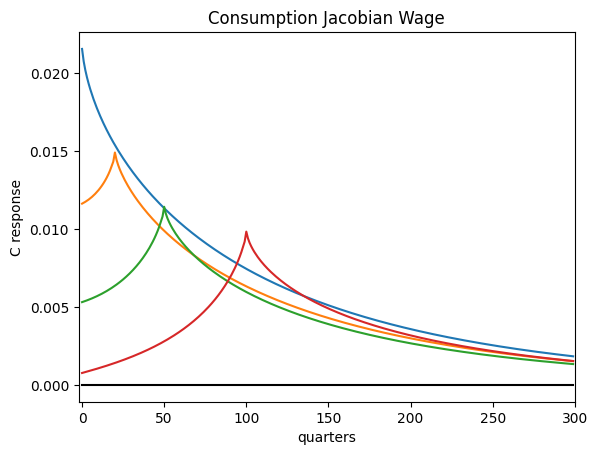

In [15]:
plt.plot(CJACW.T[0])
plt.plot(CJACW.T[20])
plt.plot(CJACW.T[50])
plt.plot(CJACW.T[100])
plt.xlim(-2,300)
plt.plot(np.arange(300),np.zeros(300), color ='k')
plt.title('Consumption Jacobian Wage')
plt.xlabel('quarters')
plt.ylabel('C response')
plt.show()

In [16]:
start  = time.time()

CJACR, AJACR = Agent_GE.calc_jacobian('Rfree',300)  # Rfree jacobians

print('Time taken to compute jacobians', time.time() - start)

Time taken to compute jacobians 2.785460948944092


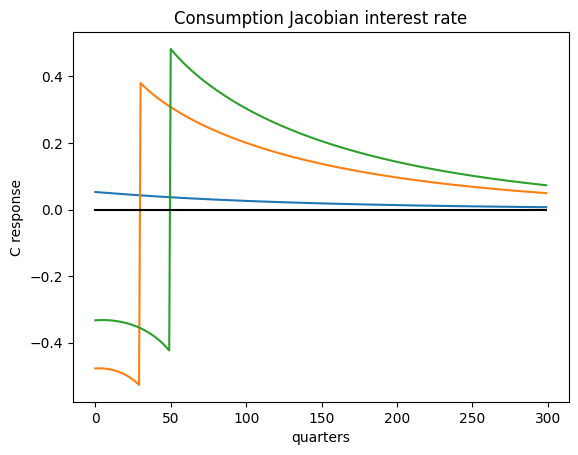

In [17]:
plt.plot(CJACR.T[0])
plt.plot(CJACR.T[30])
plt.plot(CJACR.T[50])
plt.plot(np.arange(300),np.zeros(300), color ='k')
plt.title('Consumption Jacobian interest rate')
plt.xlabel('quarters')
plt.ylabel('C response')
plt.show()

In [18]:
# Store Jacobians in JacobianDict Object
Jacobian_Dict = JacobianDict( { 'C' : {'w' : CJACW, 
                                       'r' : CJACR, 
                                           } ,
                                    
                                    'A' : {'w' : AJACW,
                                           'r' : AJACR, 
                                         } } )

# Construct SteadyStateDict object
SteadyState_Dict = SteadyStateDict({"asset_mkt":0.0,
                                    "goods_mkt":0.0,
                                    
                                    "r": r_ss,
                                    "Y": Y_ss,
                                    "A": K_ss,
                                    "C": C_ss,
                                    "Z": Z_ss,
                                    "delta": calibration['delta'],
                                    "alpha": calibration['alpha'],
                                    "L": L_ss,
                                    "K": K_ss,
                                    'w': w_ss
                            
                                    
                       })

## Other Blocks of the Model

In [19]:
@simple
def firm(K, L, Z, alpha, delta):
    r = alpha * Z * (K(-1) / L) ** (alpha-1) - delta
    w = (1 - alpha) * Z * (K(-1) / L) ** alpha
    Y = Z * K(-1) ** alpha * L ** (1 - alpha)
    return r, w, Y

@simple
def mkt_clearing(K, A, Y, C, delta):

    I = K - (1 - delta)*K(-1)
    asset_mkt = A - K
    goods_mkt = Y - C -I
    return asset_mkt, goods_mkt

In [20]:
ks = create_model([Jacobian_Dict, firm, mkt_clearing], name="Krusell-Smith")

# Solving for Impulse Responses

In [21]:


T = 300  # <-- the length of the IRF
rho_Z = 0.8 # persistence of IRF shock
dZ = 0.001 *Z_ss* rho_Z ** np.arange(T)
shocks = {'Z': dZ}

inputs = ['Z']
unknowns = ['K']
targets = ['asset_mkt']


irfs_Z = ks.solve_impulse_linear(SteadyState_Dict, unknowns, targets, shocks)


In [22]:
def show_irfs(irfs_list, variables, labels=[" "], ylabel=r"Percentage points (dev. from ss)", T_plot=50, figsize=(18, 6)):
    if len(irfs_list) != len(labels):
        labels = [" "] * len(irfs_list)
    n_var = len(variables)
    fig, ax = plt.subplots(1, n_var, figsize=figsize, sharex=True)
    for i in range(n_var):
        # plot all irfs
        for j, irf in enumerate(irfs_list):
            ax[i].plot( irf[variables[i]][:50], label=labels[j])
        ax[i].set_title(variables[i])
        ax[i].set_xlabel(r"$t$")
        if i==0:
            ax[i].set_ylabel(ylabel)
        ax[i].legend()
    plt.show()

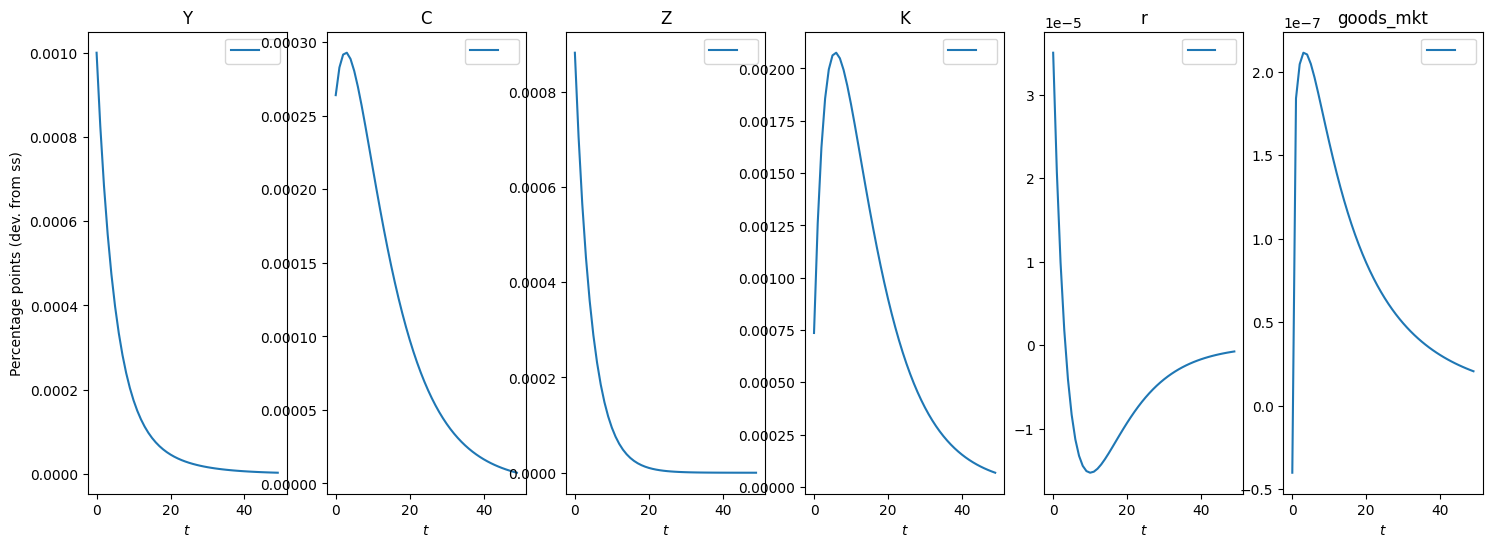

In [23]:
# Impulse Responses to Productivity Shock
show_irfs([irfs_Z], [ 'Y', 'C','Z', 'K','r', 'goods_mkt'])


# Simulating the model

In [24]:
from estimation.routines import simulate, log_priors, back_out_shocks
from estimation.plots import plot_timeseries, plot_impulses, plot_decomp


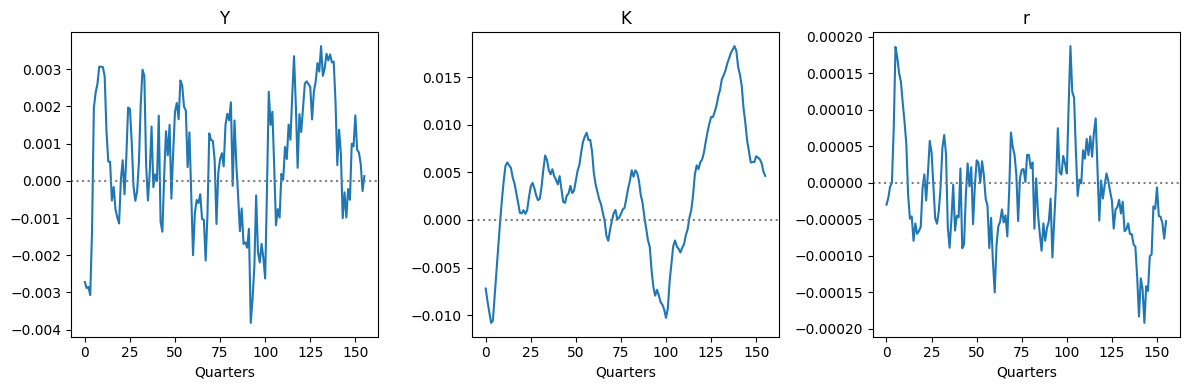

In [25]:
outputs = ['Y', 'K', 'r']

sigmas = {'Z': .001}
rhos = {'Z': 0.8}
impulses = {}


for i in inputs:
    
    own_shock = {i: sigmas[i] * rhos[i]**np.arange(T)}
    impulses[i] = ks.solve_impulse_linear(SteadyState_Dict, unknowns, targets, own_shock)
        
    
T_sim = 156  # 39 years, as in the original SW (2007) sample
data_simul = simulate(list(impulses.values()), outputs, T_sim)
plot_timeseries(data_simul, (1,3), figsize=(12, 4))